<a href="https://colab.research.google.com/github/sheikhhanif/loan_repay/blob/main/loan_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
MoneyLion's ongoing effort involves continuously improving the ability to evaluate the risk of the loan applicants more precisely. Achieving success in this endeavor allows to enhance it's customer pricing strategies and effectively manage potential losses within it's loan portfolio.

## Objective
- to predict the loan risk or quality (loan repayment) on a given applicant based on the dataset provided (loan, payment and clarity_underwriting variable)

## Let's begin
Before I proceeed to the coding I have gone through the assignment guidelines and data dictionaries and took several power naps in the middle.

In [2]:
## I use google coalaboratory to run the entire experiment. Syncing colab with the google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
## Imporing necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score



## Data preparation

In [4]:
# loading loan data
loan_data = pd.read_csv('/content/gdrive/MyDrive/moneylion_ds/loan.csv', parse_dates=['applicationDate', 'originatedDate'])

# let's look into the features and null entries
loan_data.isnull().sum()

loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
hasCF                                    0
dtype: int64

In [5]:
# dropping columns with too many null entries and irrelevant to the analysis
loan = loan_data.drop(columns=['fpStatus',  'originated', 'approved', 'hasCF' ], axis=1)
loan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clarityFraudId
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,NaT,0.0,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,5669ef78e4b0c9d3936440e6
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,569eb3a3e4b096699f685d64
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,NaT,0.0,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,579eab11e4b0d0502870ef2f
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,NaT,0.0,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,555b1e95e4b0f6f11b267c18
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,NaT,0.0,0,Rejected,350.0,814.37,NV,bvMandatory,3,5754a91be4b0c6a2bf424772


In [6]:
# loading payment data
payment_data = pd.read_csv('/content/gdrive/MyDrive/moneylion_ds/payment.csv')

# let's look into the features and null entries
payment_data.isnull().sum()

loanId                    0
installmentIndex          0
isCollection              0
paymentDate               0
principal                 0
fees                      0
paymentAmount             0
paymentStatus             0
paymentReturnCode    657831
dtype: int64

In [7]:
# dropping columns with too many null entries and irrelevant to the analysis
payment = payment_data.drop(columns=['paymentReturnCode'], axis=1)
payment.head()

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked


In [8]:
# loading payment clarity_uw_var_data
clarity_uw_var_data = pd.read_csv('/content/gdrive/MyDrive/moneylion_ds/clarity_underwriting_variables.csv', low_memory=False)

# let's look into the features and null entries
clarity_uw_var_data.isnull().sum()

.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                        2
.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                                   2
.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                         2
.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                           2
.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                        2
.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago                                         2
.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago                                        2
.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago                                       2
.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago                                2
.underwritingdatacl

In [9]:
# keeping relevant feature to the analysis
clarity_uw_var = clarity_uw_var_data[['underwritingid', 'clearfraudscore']]
clarity_uw_var.head()

,underwritingid,clearfraudscore
0,54cbffcee4b0ba763e43144d,871.0
1,54cc0408e4b0418d9a7f78af,397.0
2,54cc0683e4b0418d9a80adb6,572.0
3,54cc0780e4b0ba763e43b74a,838.0
4,54cc1d67e4b0ba763e445b45,768.0


In [10]:
# merging loan and payment data using loanId
data = loan.merge(payment , on="loanId")
data.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,isFunded,loanStatus,loanAmount,...,leadType,leadCost,clarityFraudId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,prescreen,0,569eb3a3e4b096699f685d64,1,False,2016-01-27T05:00:00,151.98,114.49,266.47,Checked
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,prescreen,0,569eb3a3e4b096699f685d64,2,False,2016-02-10T05:00:00,49.08,217.39,266.47,Checked
2,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,prescreen,0,569eb3a3e4b096699f685d64,3,False,2016-02-24T05:00:00,52.83,213.64,266.47,Checked
3,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,prescreen,0,569eb3a3e4b096699f685d64,4,False,2016-03-09T05:00:00,56.86,209.61,266.47,Checked
4,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,prescreen,0,569eb3a3e4b096699f685d64,5,False,2016-03-23T04:00:00,61.20,205.27,266.47,Checked


In [11]:
# merging with clarity underwiring data
dataset = data.merge(clarity_uw_var, left_on='clarityFraudId', right_on='underwritingid', how='left')

# let's look into the features and null entries
dataset.isnull().sum()

loanId                                   0
anon_ssn                                 0
payFrequency                             0
apr                                      0
applicationDate                          0
originatedDate                         269
nPaidOff                               383
isFunded                                 0
loanStatus                               0
loanAmount                               0
originallyScheduledPaymentAmount         0
state                                    0
leadType                                 0
leadCost                                 0
clarityFraudId                      115552
installmentIndex                         0
isCollection                             0
paymentDate                              0
principal                                0
fees                                     0
paymentAmount                            0
paymentStatus                            0
underwritingid                      131038
clearfrauds

In [12]:
len(dataset)

689364

In [13]:
# the dataset has enough observations. let's drop the null entries for comprehensive analysis
dataset = dataset.dropna()

# filtering further by isFunded where the loan was actually funded to the applicant's account
dataset = dataset.loc[dataset['isFunded'] == 1]

In [14]:
# let's have a glance at the aggregated dataset
dataset.head(10)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,isFunded,loanStatus,loanAmount,...,clarityFraudId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,1,False,2016-01-27T05:00:00,151.98,114.49,266.47,Checked,569eb3a3e4b096699f685d64,879.0
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,2,False,2016-02-10T05:00:00,49.08,217.39,266.47,Checked,569eb3a3e4b096699f685d64,879.0
2,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,3,False,2016-02-24T05:00:00,52.83,213.64,266.47,Checked,569eb3a3e4b096699f685d64,879.0
3,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,4,False,2016-03-09T05:00:00,56.86,209.61,266.47,Checked,569eb3a3e4b096699f685d64,879.0
4,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,5,False,2016-03-23T04:00:00,61.20,205.27,266.47,Checked,569eb3a3e4b096699f685d64,879.0
5,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,6,False,2016-04-06T04:00:00,65.87,200.60,266.47,Checked,569eb3a3e4b096699f685d64,879.0
6,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,7,False,2016-04-20T04:00:00,70.90,195.57,266.47,Checked,569eb3a3e4b096699f685d64,879.0
7,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,8,False,2016-05-04T04:00:00,76.31,190.16,266.47,Checked,569eb3a3e4b096699f685d64,879.0
8,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,9,False,2016-05-18T04:00:00,82.14,184.33,266.47,Checked,569eb3a3e4b096699f685d64,879.0
9,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,1,Paid Off Loan,3000.0,...,569eb3a3e4b096699f685d64,10,False,2016-06-01T04:00:00,88.40,178.06,266.46,Checked,569eb3a3e4b096699f685d64,879.0


## Feature engineering
- let's derive some new features

In [15]:
## how long it takes to get loan approved
dataset['days_between_application_and_origination'] = (dataset['originatedDate'] - dataset['applicationDate']).dt.days

In [16]:
# Fraud Score Catetory
dataset['fraudScoreCategory'] = pd.cut(dataset['clearfraudscore'], bins=[0, 300, 600, float('inf')], labels=['Low', 'Medium', 'High'])


In [17]:
# Loan amount category
dataset['loanAmountCategory'] = pd.qcut(dataset['loanAmount'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'])

In [18]:
# Calculate the ratio of the loan amount to the annual percentage rate (APR)
dataset['loan_amount_to_apr_ratio'] = dataset['loanAmount'] / dataset['apr']

In [19]:
# Creating target variable. The feature called 'loanStatus' shows whether  a approved loan is paid fully or not.
# Define a mapping dictionary for target labels
label_mapping = {
    'Settled Bankruptcy': 0,
    'Charged Off': 0,
    'Paid Off Loan': 1,
    'Settlement Paid Off': 1
}

# Use the mapping dictionary to create a new 'loanEligible' column
dataset['loanEligible'] = dataset['loanStatus'].map(label_mapping)

# Drop rows with no lable_mapping
dataset = dataset.dropna(subset=['loanEligible']).reset_index(drop=True)


In [20]:
# let's have a look at all the columns in the dataset
dataset.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originatedDate', 'nPaidOff', 'isFunded', 'loanStatus', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'clarityFraudId', 'installmentIndex', 'isCollection', 'paymentDate',
       'principal', 'fees', 'paymentAmount', 'paymentStatus', 'underwritingid',
       'clearfraudscore', 'days_between_application_and_origination',
       'fraudScoreCategory', 'loanAmountCategory', 'loan_amount_to_apr_ratio',
       'loanEligible'],
      dtype='object')

## Data Visualization

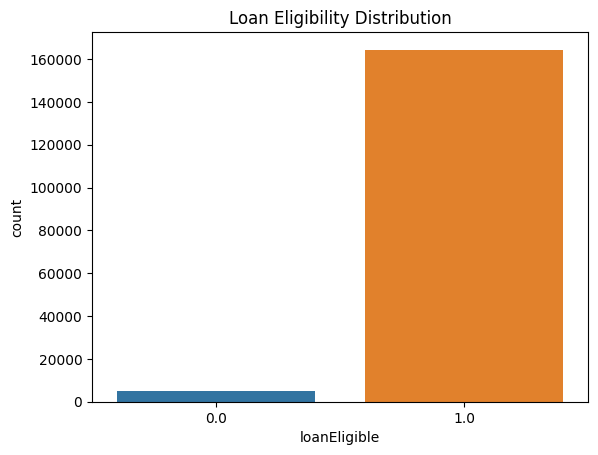

In [21]:
# the outcome feature 'loanEligible' distribution
sns.countplot(data=dataset, x='loanEligible')
plt.title('Loan Eligibility Distribution')
plt.show()

The bar chart represents 'loanEligible' feature is highly imbalanced. this has to be dealt carefully before modeling.

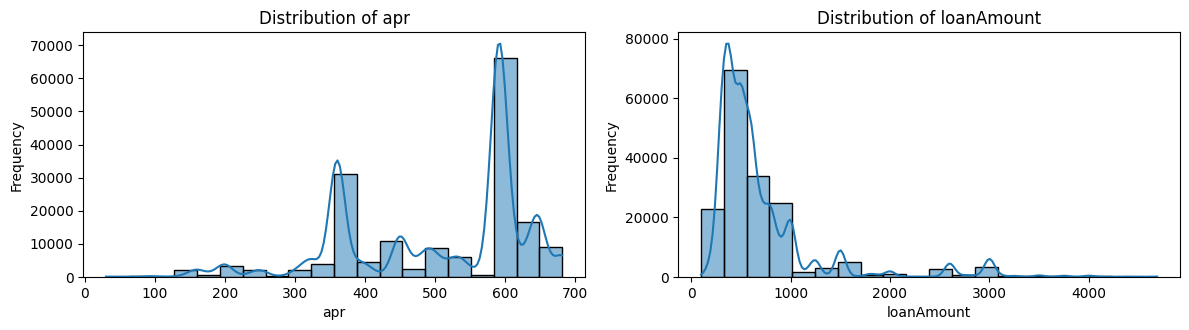

In [22]:
# Histograms for numerical features
numeric_features = ['apr', 'loanAmount']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dataset[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

It shows that 'apr' mostly between 300-400 and loan amount mostly within 1000 limit.

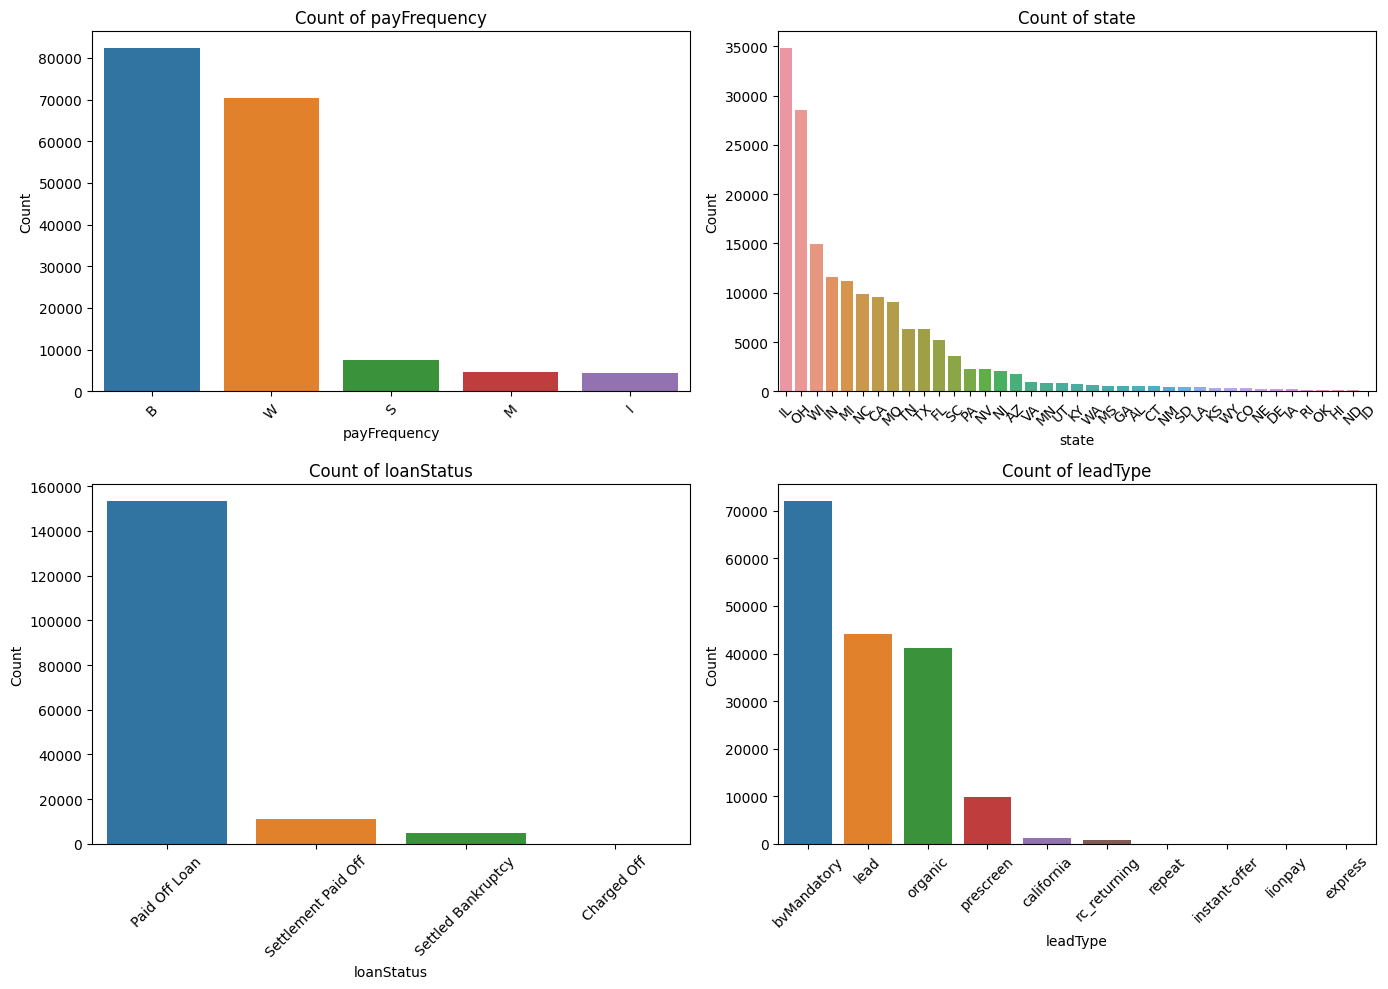

In [23]:
# Univariate Analysis of Categorical Features
categorical_features = ['payFrequency', 'state', 'loanStatus', 'leadType']

# Bar plots for categorical features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=dataset, x=feature, order=dataset[feature].value_counts().index)
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


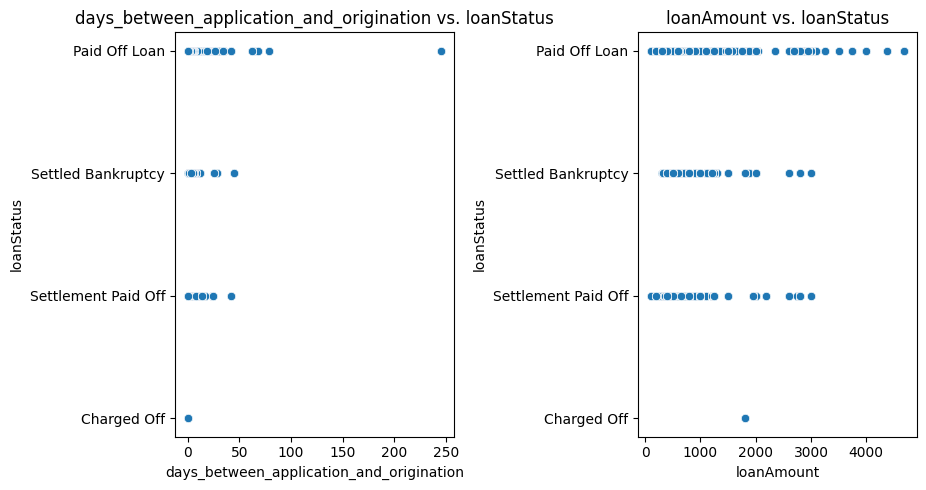

In [24]:
# Bivariate Analysis with Numerical Features
numeric_features = ['days_between_application_and_origination', 'loanAmount']
target_variable = 'loanStatus'

# Scatterplots with target variable
plt.figure(figsize=(14, 5))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=dataset, x=feature, y=target_variable)
    plt.title(f'{feature} vs. {target_variable}')
    plt.xlabel(feature)
    plt.ylabel(target_variable)
plt.tight_layout()
plt.show()

loan status is charged off and/or settled bankruptcy when the loan application is originated fast and the amount is high.

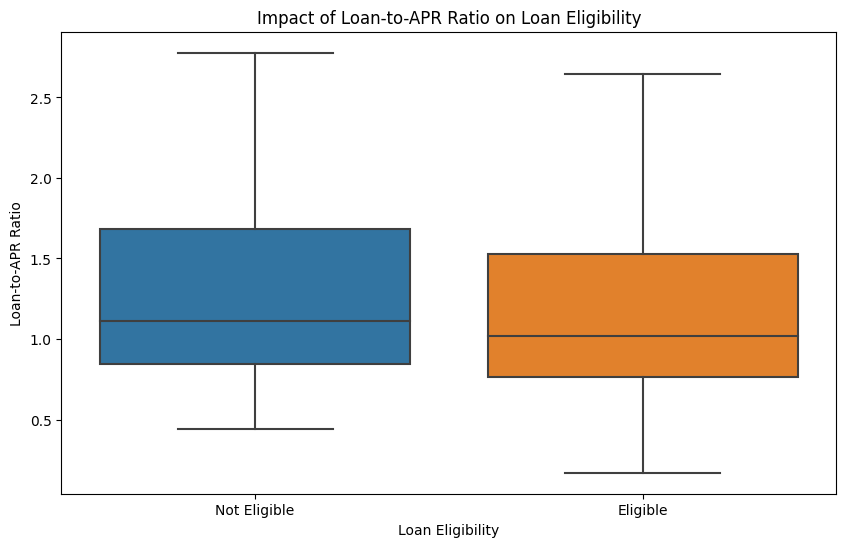

In [25]:
# Calculate the loan-to-APR ratio
dataset['loan_to_apr_ratio'] = dataset['loanAmount'] / dataset['apr']

# Create a box plot to analyze the impact on loan eligibility
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x='loanEligible', y='loan_to_apr_ratio', showfliers=False)
plt.title('Impact of Loan-to-APR Ratio on Loan Eligibility')
plt.xlabel('Loan Eligibility')
plt.ylabel('Loan-to-APR Ratio')
plt.xticks([0, 1], ['Not Eligible', 'Eligible'])
plt.show()

The boxplot shows Higher the loan-to-apr ratio the higher the risk or the applicant most likely not eligible for loan

In [26]:
# Extract month and year for application and origination dates
dataset['ApplicationMonthYear'] = dataset['applicationDate'].dt.month
dataset['OriginationMonthYear'] = dataset['originatedDate'].dt.month

# Count the number of loan applications and originations per month
applications_per_month = dataset['ApplicationMonthYear'].value_counts().sort_index()
originations_per_month = dataset['OriginationMonthYear'].value_counts().sort_index()



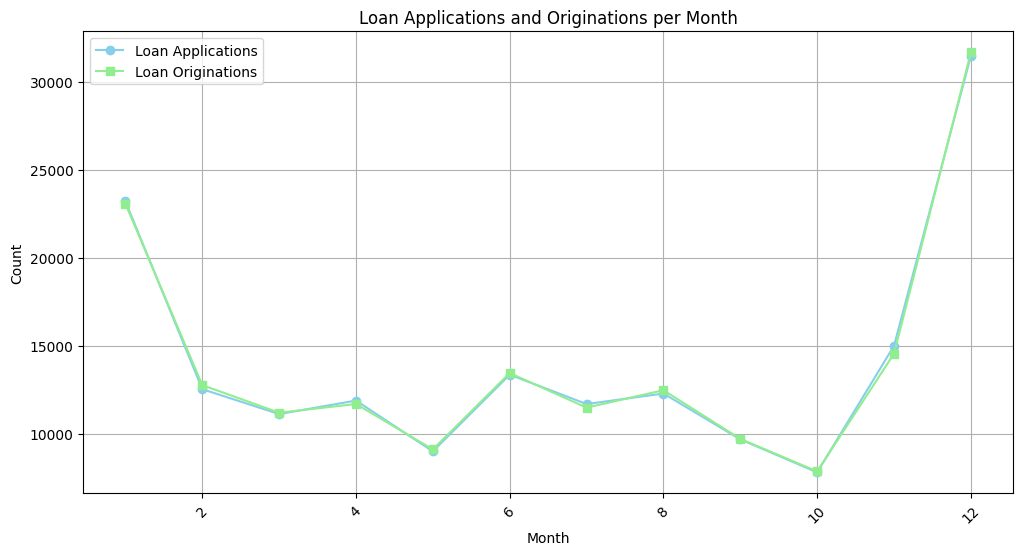

In [27]:
# Plot both trends on a single graph
plt.figure(figsize=(12, 6))
plt.plot(applications_per_month.index, applications_per_month.values, label='Loan Applications', marker='o', color='skyblue')
plt.plot(originations_per_month.index, originations_per_month.values, label='Loan Originations', marker='s', color='lightgreen')
plt.title('Loan Applications and Originations per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

It shows highter loan originations ratio and beginning and end of the year Moneylion tends to get more loan applicants.

<ipython-input-28-db1b315c975b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset.corr()


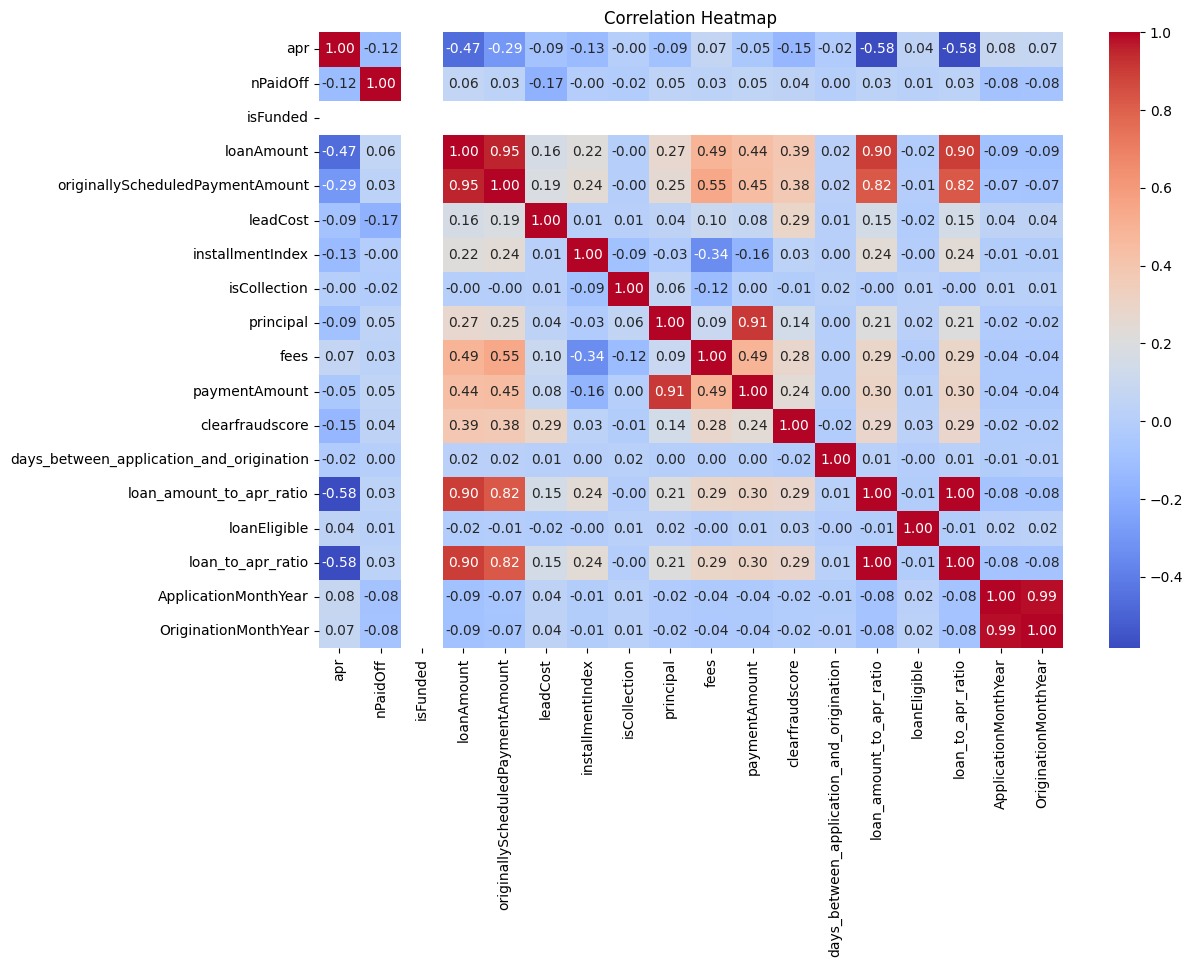

In [28]:
# Correlation heatmap
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The correlation matrix shows not all feature has correlation with our target feature 'loanEligible'. More features to be dropped prior to build model.

## Model
Prior to bulid the model few things to handle.

- dropping unnecessary columns especially columns for payment data.  The model is for to determine whether to approve loan to an applicant ('loanEligibility') or not. Since payment info come after the loan is approved. The features from the payment data has to be dropped.

- categorical data need to be transformed into numerical (one-hot encoding will be helpful)

- dealing with imbalanced data (as mentioned earlier)

- finally scaling the dataset

In [29]:
# choosing the relevant features
df = dataset[['apr', 'days_between_application_and_origination', 'payFrequency', 'nPaidOff', 'loanAmount', 'leadType', 'leadCost', 'clearfraudscore', 'loanEligible']]

In [30]:
# determining the categorical value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169152 entries, 0 to 169151
Data columns (total 9 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   apr                                       169152 non-null  float64
 1   days_between_application_and_origination  169152 non-null  int64  
 2   payFrequency                              169152 non-null  object 
 3   nPaidOff                                  169152 non-null  float64
 4   loanAmount                                169152 non-null  float64
 5   leadType                                  169152 non-null  object 
 6   leadCost                                  169152 non-null  int64  
 7   clearfraudscore                           169152 non-null  float64
 8   loanEligible                              169152 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 11.6+ MB


In [31]:
# transforming categorical data into numeric
cat_features = ['payFrequency', 'leadType']
df = pd.get_dummies(df, columns = cat_features)

In [32]:
# simple check
df.head()

,apr,days_between_application_and_origination,nPaidOff,loanAmount,leadCost,clearfraudscore,loanEligible,payFrequency_B,payFrequency_I,payFrequency_M,...,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,199.0,0,0.0,3000.0,0,879.0,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,199.0,0,0.0,3000.0,0,879.0,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,199.0,0,0.0,3000.0,0,879.0,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,199.0,0,0.0,3000.0,0,879.0,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,199.0,0,0.0,3000.0,0,879.0,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


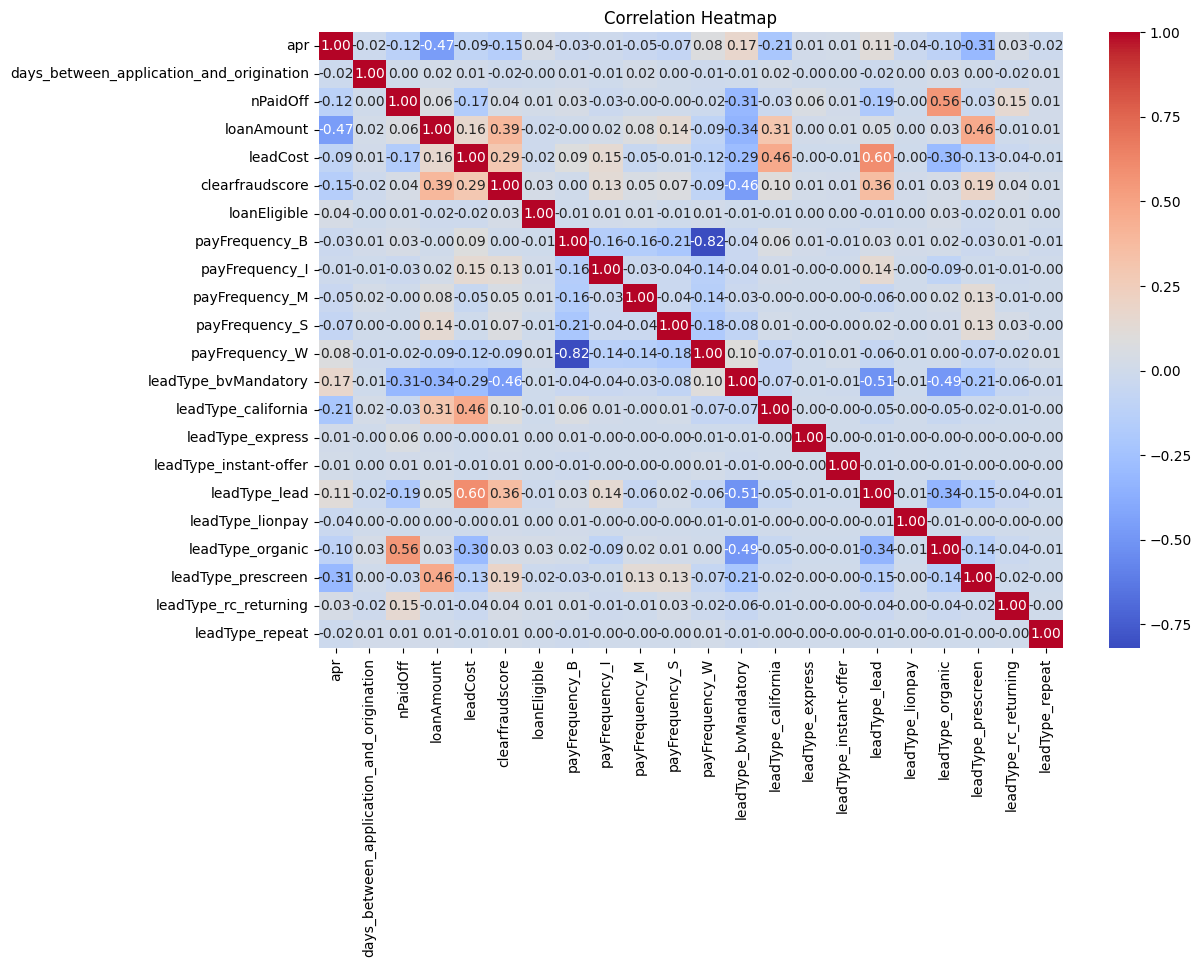

In [33]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

That's great. From the correlation matrix it's obvious that almost all the features has some level of correction with our outcome feature (loanEligible)

In [34]:
# Separate majority and minority classes
majority_class = df[df['loanEligible'] == 1]
minority_class = df[df['loanEligible'] == 0]

# Upsample the minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority_class, minority_upsampled])


# spliting dataset into train test
X_train, X_test, y_train, y_test = train_test_split(balanced_df.drop(columns=['loanEligible']), balanced_df['loanEligible'], test_size=0.2, random_state=42)


In [35]:
# Define the classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('Support Vector Machine', SVC(kernel='linear', C=1.0, random_state=42))
]

# Create a list to store pipeline results
pipeline_results = []

# Create and evaluate pipelines for each classifier
for classifier_name, classifier in classifiers:
    # Create a pipeline with scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Eligible', 'Eligible'])

    # Store results in a dictionary
    result = {
        'Classifier': classifier_name,
        'Accuracy': accuracy,
        'Classification Report': report
    }

    pipeline_results.append(result)

# Print the results
for result in pipeline_results:
    print(f"Classifier: {result['Classifier']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print("Classification Report:")
    print(result['Classification Report'])
    print("-" * 50)


Classifier: Logistic Regression
Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

Not Eligible       0.59      0.60      0.60     32833
    Eligible       0.60      0.59      0.59     32908

    accuracy                           0.59     65741
   macro avg       0.59      0.59      0.59     65741
weighted avg       0.59      0.59      0.59     65741

--------------------------------------------------
Classifier: Random Forest
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

Not Eligible       1.00      1.00      1.00     32833
    Eligible       1.00      1.00      1.00     32908

    accuracy                           1.00     65741
   macro avg       1.00      1.00      1.00     65741
weighted avg       1.00      1.00      1.00     65741

--------------------------------------------------
Classifier: Gradient Boosting
Accuracy: 0.78
Classification Report:
              precision    recall  f1-scor


The best model is: Random Forest with Accuracy: 1.00

Top 10 Important Features:
                                     Feature  Importance
5                            clearfraudscore    0.383939
3                                 loanAmount    0.181537
0                                        apr    0.154711
1   days_between_application_and_origination    0.087819
4                                   leadCost    0.081031
2                                   nPaidOff    0.023453
10                            payFrequency_W    0.020941
6                             payFrequency_B    0.019398
17                          leadType_organic    0.009374
9                             payFrequency_S    0.007677


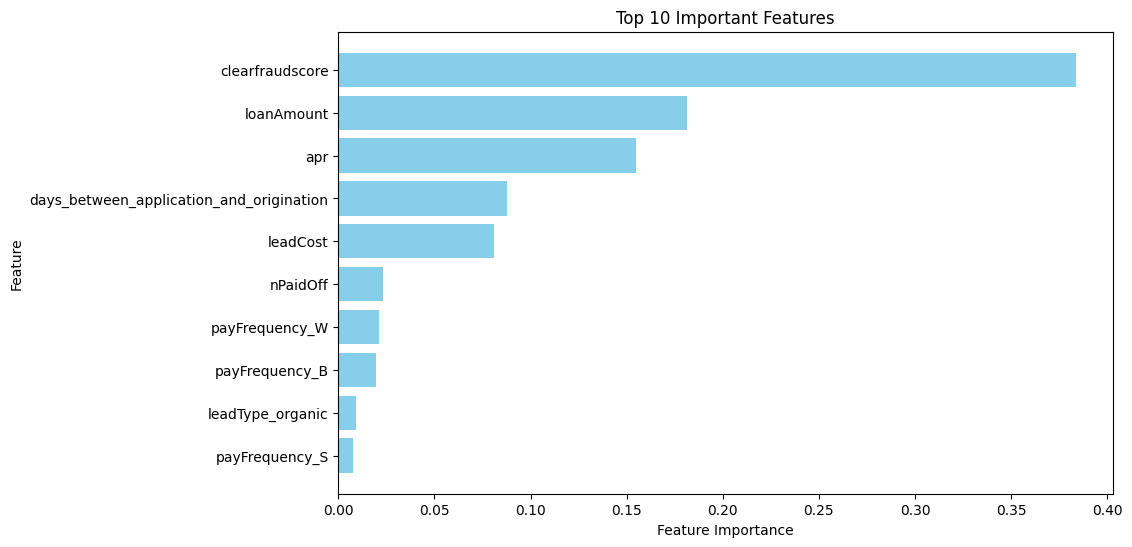

In [52]:
# Find the best-performing model
best_model_result = max(pipeline_results, key=lambda x: x['Accuracy'])
best_model_name = best_model_result['Classifier']
print(f"\nThe best model is: {best_model_name} with Accuracy: {best_model_result['Accuracy']:.2f}")

# If the best model is Random Forest, you can extract feature importance
if best_model_name == 'Random Forest':
    best_classifier = classifiers[1][1]  # Random Forest
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', best_classifier)
    ])

    best_pipeline.fit(X_train, y_train)

    # Get feature importances
    feature_importances = best_classifier.feature_importances_

    # Create a DataFrame to associate feature names with their importance scores
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    top_n = 10  # Change this value to see more or fewer top features
    top_features = importance_df.head(top_n)

    print("\nTop", top_n, "Important Features:")
    print(top_features)

    # Create a bar plot to visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Important Features')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

## Conclusion and Future work
*Model Performance*: The top-performing model in this analysis is the Random Forest model, which achieved an exceptional accuracy score of 99.97%. This high score is reflected across all evaluation metrics, including precision, recall, and F1-score.

*Reliability Indicator*: The exceptionally high scores obtained by the Random Forest model serve as strong indicators of its reliability in determining the eligibility of a loan applicant.

*Simplicity of Analysis*: The current analysis of the dataset is kept relatively simple, focusing on model performance.

**Future Work**: In future research, it is recommended to conduct a more comprehensive and in-depth analysis of the dataset. This could involve exploring various aspects of the data beyond model performance.

*Custom Fraud Detection Model*: An interesting avenue for future investigation is to develop a custom fraud detection model that doesn't rely on the 'clearfraudscore' feature. Building a separate fraud score model could provide valuable insights and enhance the accuracy of loan eligibility predictions.